### Noise Injection with the Laplace Mechanism

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io

First, let's download the PUMS data and read it into a pandas dataframe.

In [2]:
r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract('psam_p42.csv')

'C:\\Users\\desai015\\Desktop\\DP\\census-dp\\notebooks\\psam_p42.csv'

This notebook explores one disclosure avoidance technique that injects Laplacian-distributed noise to tabulated PUMS data.

In [4]:
pa = pd.read_csv("psam_p42.csv")
asn_pa = pa.query('AGEP>=18 and RACASN==1')
asn_pa.groupby('RAC2P').count()
# a 2D table, row = educational attainment, col = race by RAC2P (asian ethnicity)
asn_pa_ed = asn_pa.groupby(['RAC2P','SCHL']).size().unstack()
asn_pa_ed.fillna(0)
all_pa_ed = asn_pa.groupby('SCHL').size()
asn_pa_ed.describe()

SCHL,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
count,21.000000,2.0,3.000000,6.000000,8.000000,12.000000,11.000000,12.000000,15.000000,10.000000,...,18.000000,22.000000,19.000000,22.000000,22.000000,20.000000,23.000000,22.000000,19.000000,20.000000
mean,28.142857,1.0,1.666667,1.500000,2.625000,2.916667,3.454545,5.583333,8.400000,5.600000,...,22.111111,94.636364,10.578947,30.727273,73.363636,30.550000,145.565217,89.909091,38.000000,36.150000
std,47.244350,0.0,0.577350,1.224745,2.326094,2.574643,2.423371,7.464563,12.871896,6.619836,...,32.021847,136.995845,13.459056,46.767084,113.569171,40.325615,253.861241,209.129923,69.628379,77.954963
min,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
25%,3.000000,1.0,1.500000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000,2.000000,...,4.250000,12.500000,1.000000,5.000000,5.500000,3.000000,14.000000,4.250000,2.500000,2.000000
50%,10.000000,1.0,2.000000,1.000000,2.000000,2.000000,3.000000,2.500000,3.000000,2.500000,...,6.500000,25.500000,3.000000,8.000000,17.500000,7.000000,29.000000,14.500000,8.000000,8.500000
75%,22.000000,1.0,2.000000,1.000000,3.000000,3.250000,4.500000,4.250000,11.000000,7.000000,...,15.250000,117.500000,17.500000,29.750000,84.250000,59.500000,129.000000,42.750000,41.500000,19.250000
max,204.000000,1.0,2.000000,4.000000,8.000000,9.000000,8.000000,22.000000,51.000000,22.000000,...,99.000000,477.000000,40.000000,158.000000,388.000000,119.000000,1019.000000,894.000000,288.000000,311.000000


**The Laplace Mechanism**
The input is mu - a number or a numpy array, along with the privacy budget epsilon and sensitivity of the query that produced mu.

In [3]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

### Quality Metrics

While the trade-off between statistical accuracy and privacy loss is at the heart of differential privacy, there are many metrics for assessing the quality of a published dataset. One approach is to calculate the L1 error between the true data (i.e. without disclosure limitation) and the privatized data.

**The L1 Norm** In this simple scenario involving the Laplace Mechanism, the L1 error is a natural metric. This is a coarse measure: a disclosure limited product with a high L1 compared to the same product without disclosure limitation may still be very accurate for its intended use. 

In [4]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

### Trade-off Between Privacy Loss and Accuracy

When submitting to the DRB, the practitioner prepares a set of graphs that show the trade-off between privacy loss (ϵ) and accuracy. DRB officials then picks a value of ϵ that allows for sufficient accuracy. Officials most often estimate with epsilon values between 1 and 9.

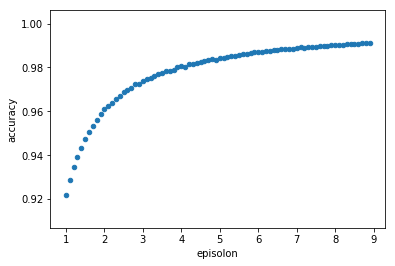

In [25]:
orig_arr = pd.DataFrame(all_pa_ed).T
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,9.0,.1)
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()

### Postprocessing

Postprocessing the output of a DP mechanism does not degrade privacy. In this case, we want to round any negative counts to zero.

In [126]:
noisy_counts = laplace_mech(orig_arr, 1)
noisy_counts

SCHL,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
0,592.339717,-2.5517,5.288189,9.645158,23.57161,37.983922,39.645628,66.140266,125.934717,56.118941,...,401.162229,2080.117632,199.704311,674.281154,1614.188426,610.793064,3346.987563,1978.664748,720.737995,722.902066


In [127]:
for i in range(1, 24):
    if noisy_counts[i].item() < 0:
        noisy_counts[i] = 0

In [128]:
noisy_counts

SCHL,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
0,592.339717,0,5.288189,9.645158,23.57161,37.983922,39.645628,66.140266,125.934717,56.118941,...,401.162229,2080.117632,199.704311,674.281154,1614.188426,610.793064,3346.987563,1978.664748,720.737995,722.902066
